In [621]:
import numpy as np
import requests
import pyprind
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
import pandas as pd
%matplotlib inline

In [622]:
# load all words vocabulary. All these words should be classified as positive samples.
positives = [w.lower() for w in np.genfromtxt('words.txt', dtype=np.str, delimiter='\n\r')]

In [623]:
positives[0:10]

['a', "a'asia", "a's", 'aa', "aa's", 'aaa', 'aaaa', 'aaaaaa', 'aaal', 'aaas']

In [624]:
def collectTrainData(samples=100):
    seeds = np.random.uniform(0, 1919415150, samples)
    bar = pyprind.ProgBar(samples, bar_char='█')
    dump = {}
    for seed in seeds:
        r = requests.get('https://hola.org/challenges/word_classifier/testcase/%d'%seed)
        json = r.json()
        dump.update(json)
        bar.update()
    return dump

In [625]:
def saveTrainData(dump):
    with open('train.txt', 'wb') as file:
        pickle.dump(dump, file)

def loadTrainData():
    with open('train.txt', 'rb') as file:
        return pickle.loads(file.read())

In [626]:
train = collectTrainData()
saveTrainData(train)

0%                          100%
[██████████████████████████████] | ETA: 00:00:00
Total time elapsed: 00:00:19


In [627]:
train = loadTrainData()

In [628]:
[(key, train[key]) for key in train.keys()][:5]

[("bedsitter's", True),
 ('zkndbglsestsqdjiht', False),
 ('sorriness', True),
 ("mppkgdbn'xuoszfm", False),
 ("edyntitinotickunci'ssurbmainakh", False)]

In [629]:
def validate(classifier, train):
    predicted = [classifier(sample) == train[sample] for sample in train]
    return np.sum(predicted)/len(train), [classifier(sample) for sample in train]

In [630]:
chars = []
for w in positives:
    for c in list(w):
        chars.append(c)

In [631]:
chars_hist = {None: len(positives)}
for c in chars:
    if c in chars_hist:
        chars_hist[c] += 1
    else:
        chars_hist[c] = 1

In [632]:
charProbs = {c: np.log(1 + chars_hist[c]/sum(chars_hist.values())) for c in chars_hist}

In [633]:
def getCharPairs(word):
    return list(zip([None] + list(word), list(word) + [None]))

charPairsHist = {}

for w in positives:
    for p in getCharPairs(w):
        if p in charPairsHist:
            charPairsHist[p] += 1
        else:
            charPairsHist[p] = 1

In [634]:
charPairsHist[(None, 'a')], charPairsHist[('a', None)]

(44922, 26851)

In [635]:
charCondProbs = {(c1, c2): np.log(1 + charPairsHist[(c1, c2)]/chars_hist[c1]) for (c1, c2) in charPairsHist}

In [636]:
len(charCondProbs)

767

In [637]:
def getWordProb(word):
    prob = 0
    for c1, c2 in list(zip([None] + list(word), list(word) + [None])):
        if not c2 in charProbs:
            return 0
        if not (c1, c2) in charCondProbs:
            return 0
        prob += (charCondProbs[(c1, c2)] if (c1, c2) in charCondProbs else 0)
    return prob

In [638]:
getWordProb('a'), charCondProbs[(None, 'a')], charProbs['a']

(0.11498709187958997, 0.065684933513879801, 0.074109719909888572)

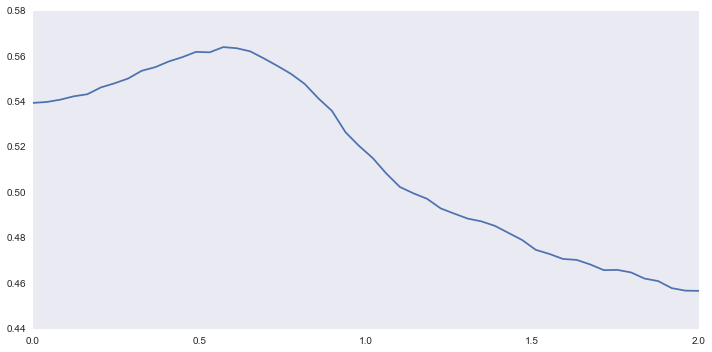

In [639]:
x = np.linspace(0, 2, num=50)
accuracy =  [validate(lambda w: getWordProb(w) > t, train)[0] for t in x]
plt.figure(figsize=(10, 5))
plt.plot(x, accuracy)
plt.tight_layout()
plt.grid()

In [640]:
len(train)

9967

In [641]:
predicted = pd.Series(validate(lambda w: getWordProb(w) > 0.6, train)[1])
actual = pd.Series(list(train.values()))
pd.crosstab(actual, predicted)

col_0,False,True
row_0,,
False,1056,3800
True,552,4559


In [642]:
def getCharTriples(word):
    wordExt = list(word) + [None, None]
    return [(wordExt[-2 + i], wordExt[-1 + i], wordExt[i]) for i in range(0, len(word) + 2)]

In [643]:
getCharTriples('abc')

[(None, None, 'a'),
 (None, 'a', 'b'),
 ('a', 'b', 'c'),
 ('b', 'c', None),
 ('c', None, None)]

In [644]:
charTriplesHist = {}

for w in positives:
    for p in getCharTriples(w):
        if p in charTriplesHist:
            charTriplesHist[p] += 1
        else:
            charTriplesHist[p] = 1

In [645]:
charTriplesCondProbs = {(c1, c2, c3): np.log(1 + charTriplesHist[(c1, c2, c3)]/(charPairsHist[(c1, c2)] if (c1, c2) in charPairsHist else charPairsHist[(c2, c3)]))\
                        for (c1, c2, c3) in charTriplesHist}

In [646]:
def getWordProbForTriples(word):
    prob = 0
    for c1, c2, c3 in getCharTriples(word):
        if not (c1, c2, c3) in charTriplesCondProbs:
            return 0
        prob += (charTriplesCondProbs[(c1, c2, c3)] if (c1, c2, c3) in charTriplesCondProbs else 0)
    return prob

In [647]:
max_word_length = np.max([len(w) for w in positives])
def lengthInRange(word):
    return len(word) < max_word_length

In [648]:
getWordProbForTriples('a'), charTriplesCondProbs[('a', 'a', 'a')]

(1.3863388817440772, 0.017837708186021449)

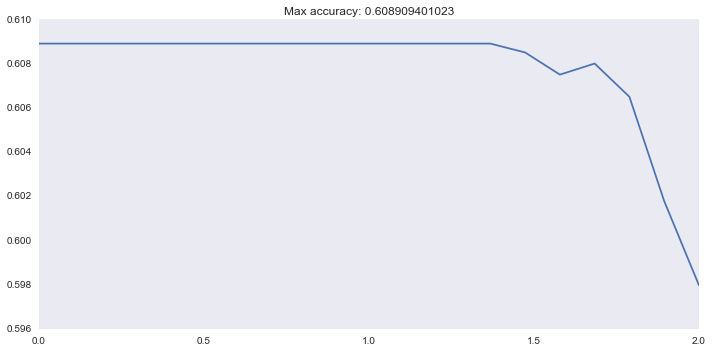

In [649]:
x = np.linspace(0, 2, num=20)
accuracy =  [validate(lambda w: getWordProbForTriples(w) > t, train)[0] for t in x]
plt.figure(figsize=(10, 5))
plt.plot(x, accuracy)
plt.title('Max accuracy: %s'%accuracy[np.argmax(accuracy)])
plt.tight_layout()
plt.grid()

In [650]:
predictedTriples = pd.Series(validate(lambda w: getWordProbForTriples(w) > 0, train)[1])
actual = pd.Series(list(train.values()))
pd.crosstab(actual, predictedTriples)

col_0,False,True
row_0,,
False,958,3898
True,0,5111
